<h1><center><b>Moneypoly</b></center></h1>

# **Contexto**

BBVA Open innovation busca automatizar la forma de valorar y monitorear la
variación del valor de los inmuebles mediante un modelo predictivo
de valoración que se alimente de información histórica y
datos del mercado. Esto es debido a los problemas que tiene el metodo tradicional de tasacion:
* El tiempo de ejecución de una tasación toma entre 2-3 días hábiles
* La gestión operativa de la tasación ocupa aproximadamente 160 horas del equipo al mes
* El BBVA gestiona aproximadamente 10M tasaciones de viviendas al año, generando un gasto de ~S/2.3MM al año

Esta la primera parte del desarrollo del prototipo.

En este notebook se realizara el analisis exploratorio de datos y transformaciones correspondientes

# **Carga de datos**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math
import seaborn as sns

Abajo se pueden visualizar los datos disponibilizados por BBVA y las primeras modificaciones son:

* Tipo de vía -> mapeo para asignar un significado a los tipos de via
* Area terreno -> los datos tienen formato texto y contienen comas en las posiciones milesimas, se omiten las comas y se convierten en numeros
* Area construccion -> los datos tienen formato texto y contienen comas en las posiciones milesimas, se omiten las comas y se convierten en numeros
* Piso -> se elimina por que mas del 95% son valores nulos
* Posicion -> se elimina por que mas del 95% son valores nulos
* Numero de frentes -> se elimina por que mas del 95% son valores nulos
* Elevador -> se elimina por que mas del 95% son valores nulos

In [2]:
map_tipo_via = {
    1:"CALLE",
    2:"JIRON",
    3:"AVENIDA",
    4:"PASAJE",
    5:"CARRETERA",
    6:"MANZANA",
    7:"LOTE",
    8:"PARCELA",
    9:"FUNDO",
    10:"SIN_VIA"
}

df_train = pd.read_excel("/kaggle/input/hackathonbbva2022datadriven/dataset_tasacion_train_vf.xlsx")
df_train["Área Terreno"] = df_train["Área Terreno"].str.replace(',','')
df_train["Área Terreno"] = df_train["Área Terreno"].astype("float64")
df_train["Área Construcción"] = df_train["Área Construcción"].str.replace(',','')
df_train["Área Construcción"] = df_train["Área Construcción"].astype("float64")
df_train["Tipo de vía"] = df_train["Tipo de vía"].map(map_tipo_via)
df_train.drop(["Piso","Posición","Número de frentes","Elevador"],inplace=True,axis=1)
df_train.head()

,Fecha entrega del Informe,Tipo de vía,Departamento,Provincia,Distrito,Número de estacionamiento,Depósitos,Latitud (Decimal),Longitud (Decimal),Categoría del bien,Edad,Estado de conservación,Método Representado,Área Terreno,Área Construcción,Valor comercial (USD)
0,2020-02-16,CALLE,Piura,Piura,Veintiseis de Octubre,NaN,NaN,-5.163182,-80.682388,Vivienda Unifamiliar,0.0,En construcción,Costos o reposición (directo),62.50,27.58,25278
1,2019-05-21,CALLE,Lima,Lima,Surquillo,1.0,0.0,-12.115286,-77.003768,Departamento,1.0,Bueno,Comparación de mercado (directo),9.32,57.47,110807
2,2020-04-11,CALLE,Junín,Satipo,Satipo,0.0,0.0,-11.235446,-74.629221,Vivienda Unifamiliar,7.0,Regular,Costos o reposición (directo),126.00,84.00,42285
3,2016-05-24,CALLE,Lima,Lima,Santiago de Surco,0.0,0.0,-12.126384,-76.975707,Oficina,0.0,NaN,Comparación de mercado (directo),8.60,82.34,165503
4,2016-01-12,AVENIDA,Lima,Lima,Lima,0.0,0.0,-12.089613,-76.994475,Vivienda Unifamiliar,43.0,NaN,Comparación de mercado (directo),357.55,423.22,711009


Tamaño del dataset

In [3]:
df_train.shape

(53254, 16)

Tipos de datos e identifiacion de columnas categoricas y numericas

In [4]:
cols_categoricas = []
cols_numericas = []
for c in df_train.columns:
    print(c+" -> "+str(df_train[c].dtype))
    print("")
    if df_train[c].dtype == "object":
        cols_categoricas.append(c)
    if df_train[c].dtype == "float64":
        cols_numericas.append(c)

Fecha entrega del Informe -> datetime64[ns]

Tipo de vía -> object

Departamento -> object

Provincia -> object

Distrito -> object

Número de estacionamiento -> float64

Depósitos -> float64

Latitud (Decimal) -> float64

Longitud (Decimal) -> float64

Categoría del bien -> object

Edad -> float64

Estado de conservación -> object

Método Representado -> object

Área Terreno -> float64

Área Construcción -> float64

Valor comercial (USD) -> int64



Aqui se encuentra la cantidad de valores nulos en cada columna

In [5]:
df_train.isnull().sum()

Fecha entrega del Informe        0
Tipo de vía                   5011
Departamento                     0
Provincia                        0
Distrito                         0
Número de estacionamiento     7924
Depósitos                     7993
Latitud (Decimal)              863
Longitud (Decimal)             917
Categoría del bien            2449
Edad                          4789
Estado de conservación       15700
Método Representado              7
Área Terreno                  1153
Área Construcción             4493
Valor comercial (USD)            0
dtype: int64

# **Distribucion de "Valor comercial (USD)"**

El grafico de abajo representa la distribucion de los valores comerciales dentro de la base de datos. Esta desbalanceada y contiene muchos valores atipicos.

Al desarrollar un modelo general para predecir el valor (usd), probablemente la mayoria de predicciones tendrian una desviacion de hasta 5 veces su valor real

Propongo buscar un metodo para agrupar los registros del dataset y aplicar un estimador particular para cada grupo.
De esa forma, es menor probable que la prediccion se desvie de su valor real

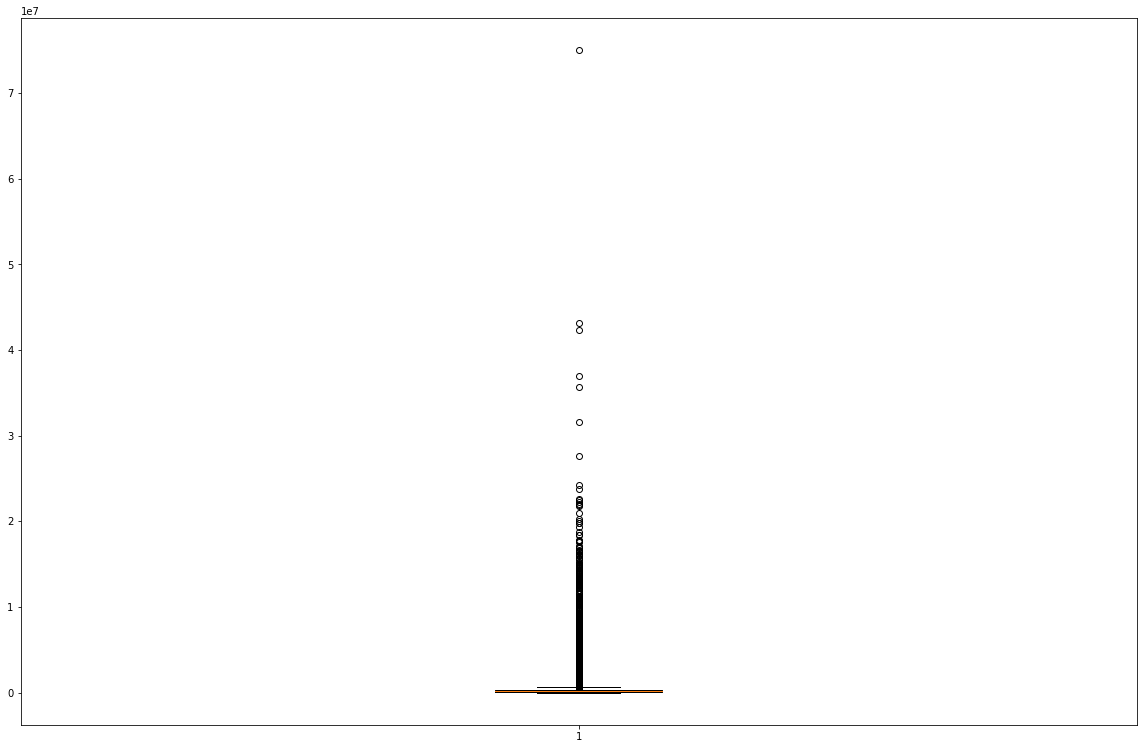

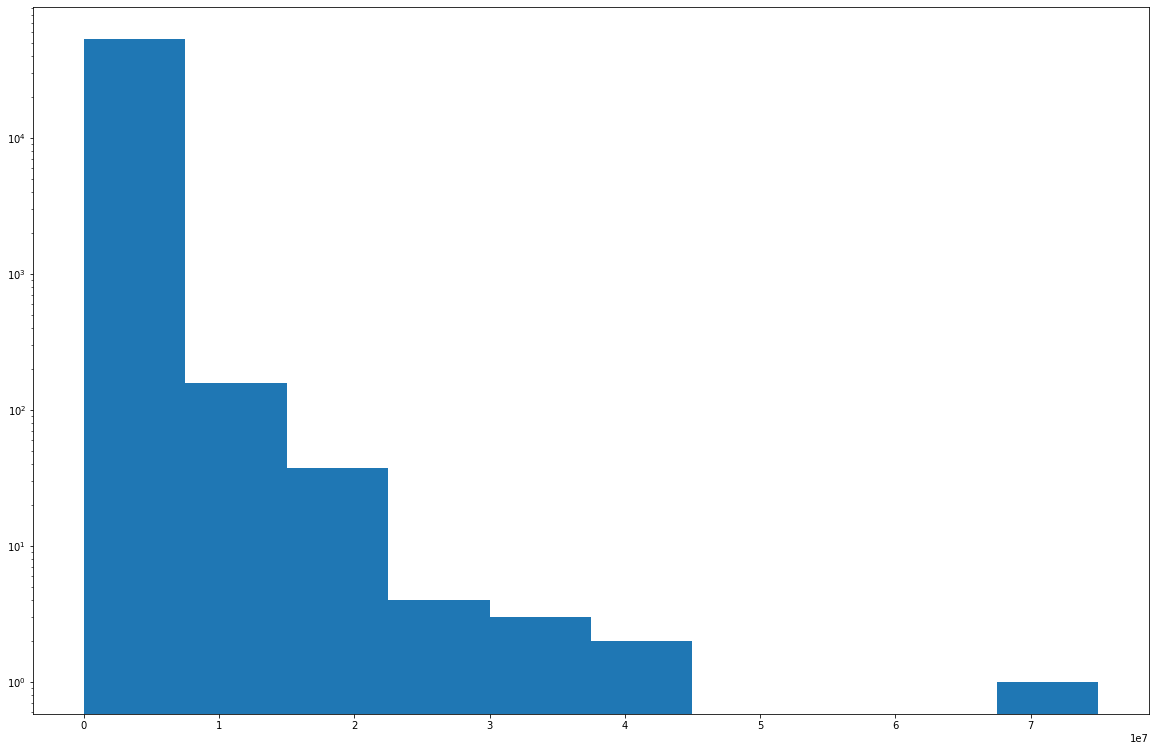

In [6]:
c = df_train["Valor comercial (USD)"].copy()

plt.figure(figsize=(20,13))
plt.boxplot(c)
plt.show()
plt.figure(figsize=(20,13))
plt.hist(c,log=True)
plt.show()

# **Distribucion de columnas categoricas**


Esta seccion permite ver las graficos de variables categoricas.
Destacados:
* La mayoria de tipos de vias son calles
* La gran mayoria de bienes se encuentran en el departamento "Lima"
* La gran mayoria de bienes se encuentran en la provincia "Lima"
* La gran mayoria de bienes se encuentran en el distrito "Santiago de Surco"
* La gran mayoria de bienes tiene un estado de conservacion "Bueno"
* La mayoria de bienes son departamentos
* La mayoria de valores se calcularon con el metodo de comparacion (principalmente por geolocalizacion)

In [7]:
cols_categoricas

['Tipo de vía',
 'Departamento',
 'Provincia',
 'Distrito',
 'Categoría del bien',
 'Estado de conservación',
 'Método Representado']

Tipo de vía


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


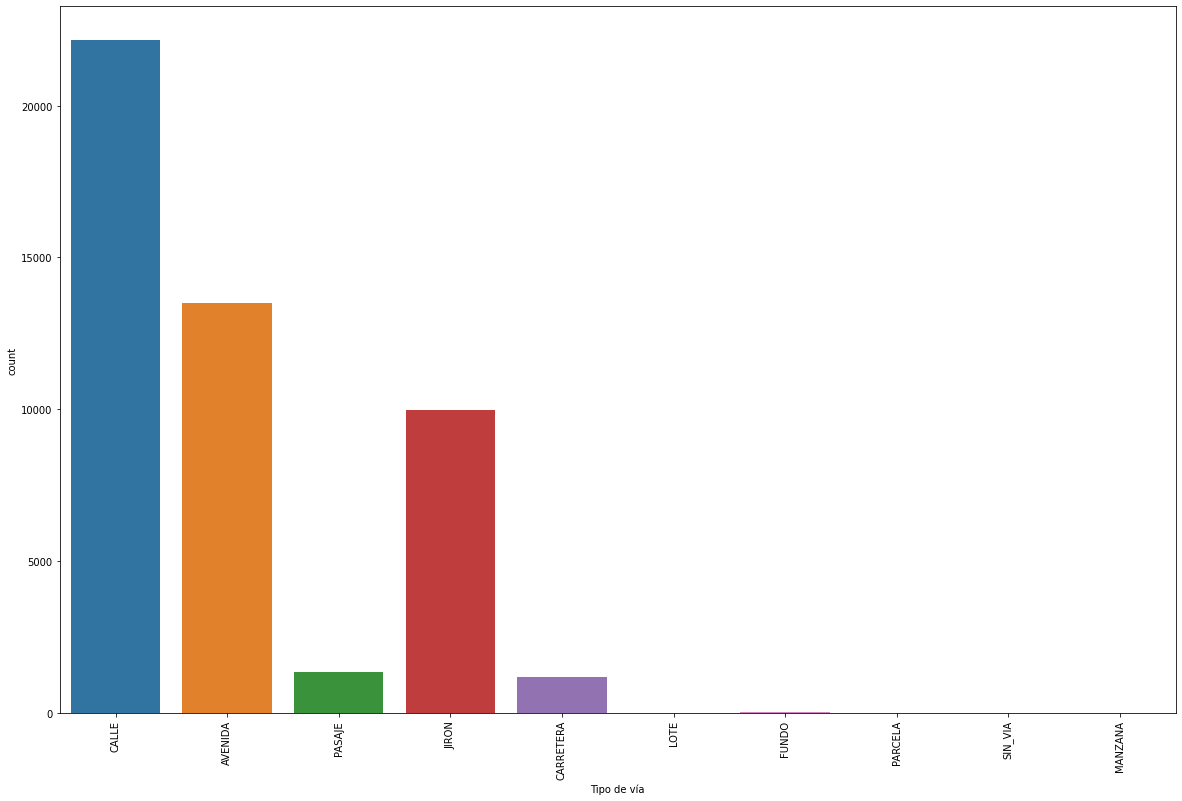

Departamento


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


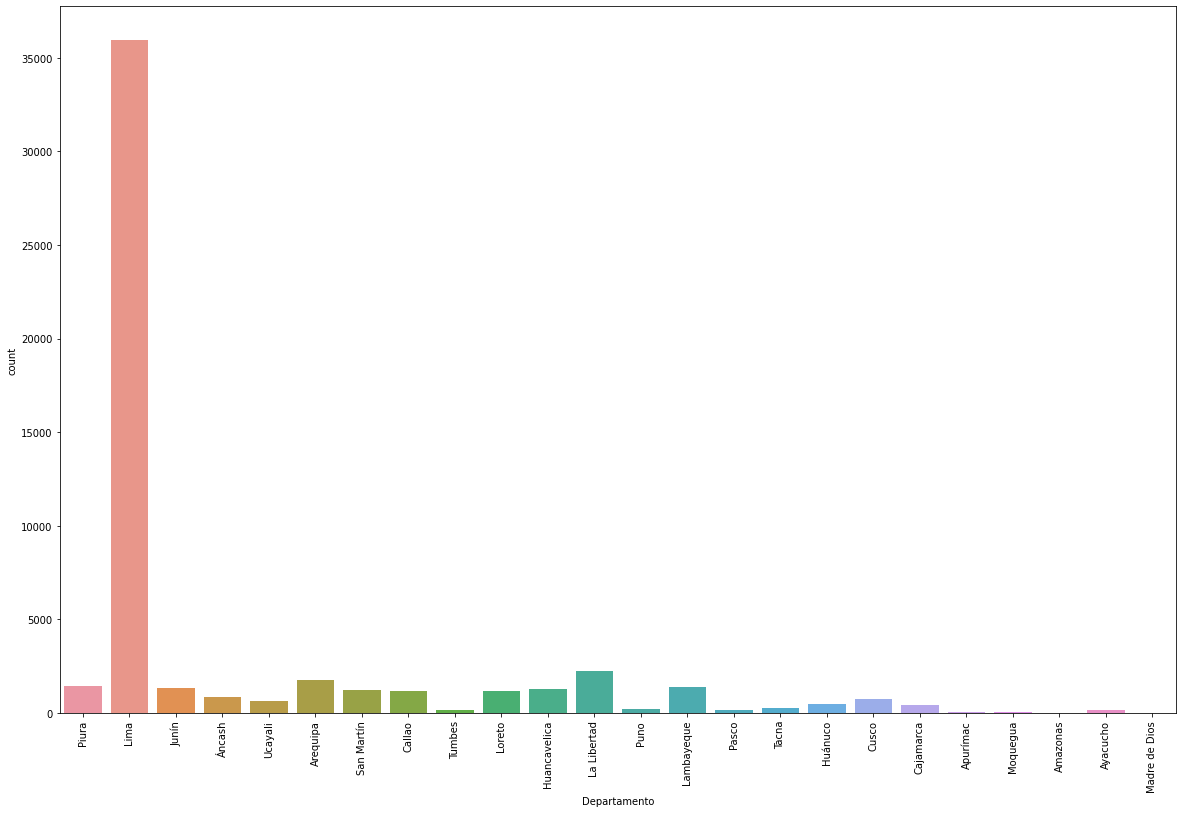

Provincia


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


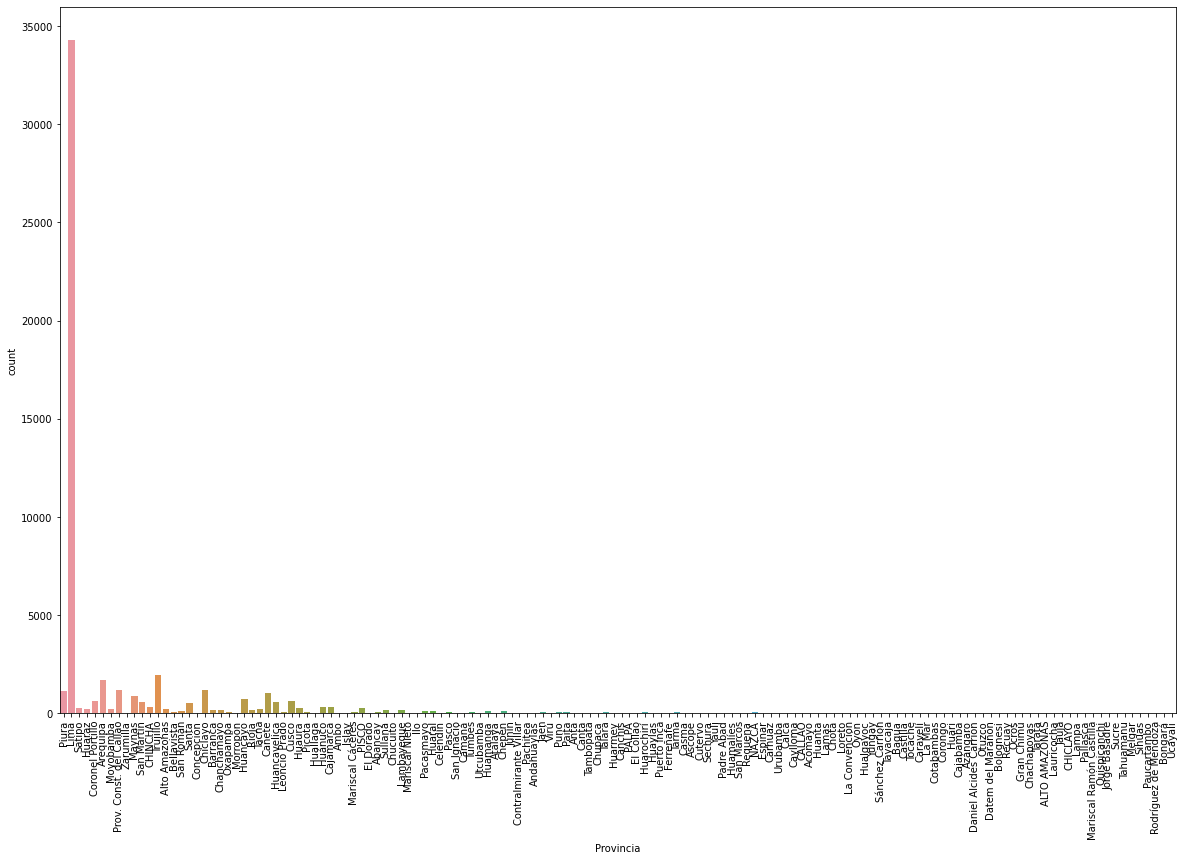

Distrito


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


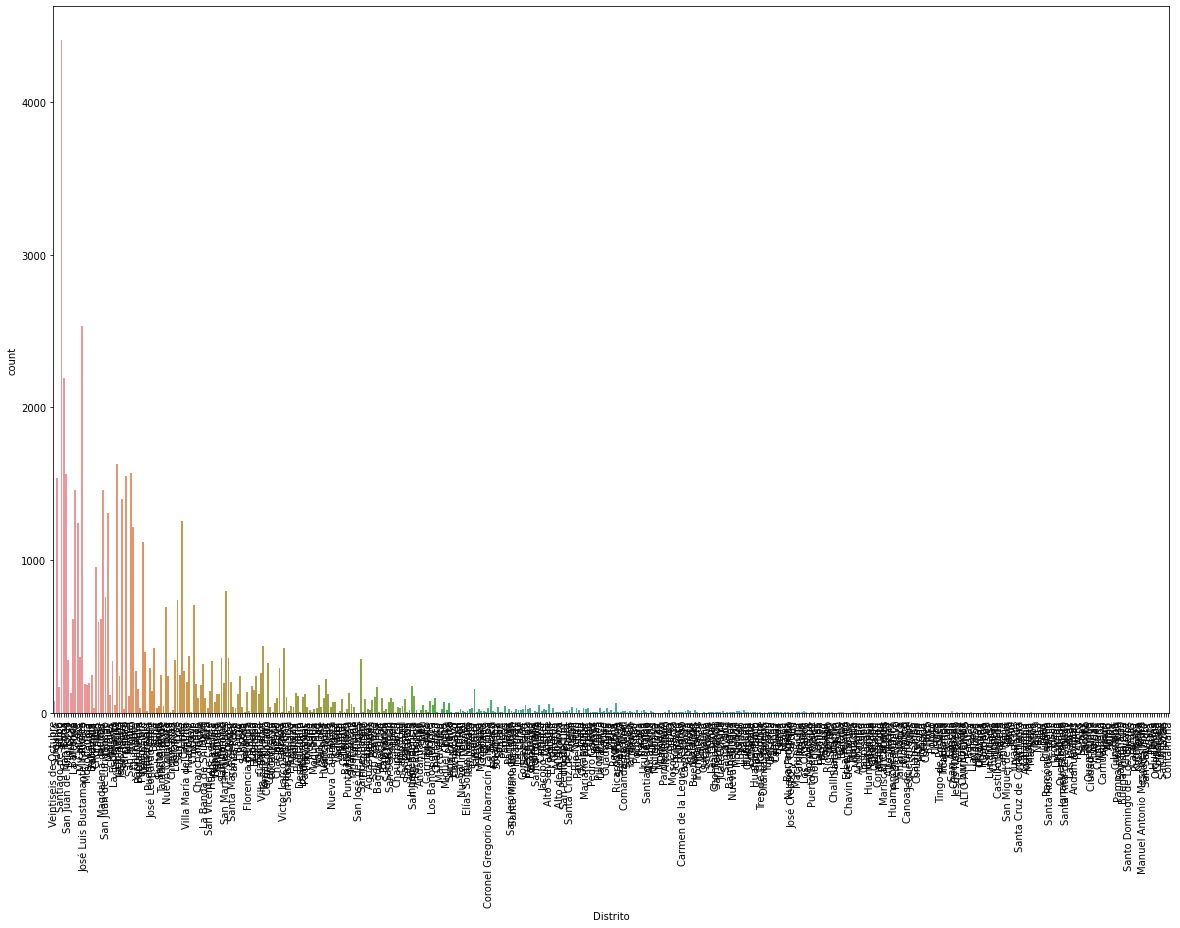

Categoría del bien


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


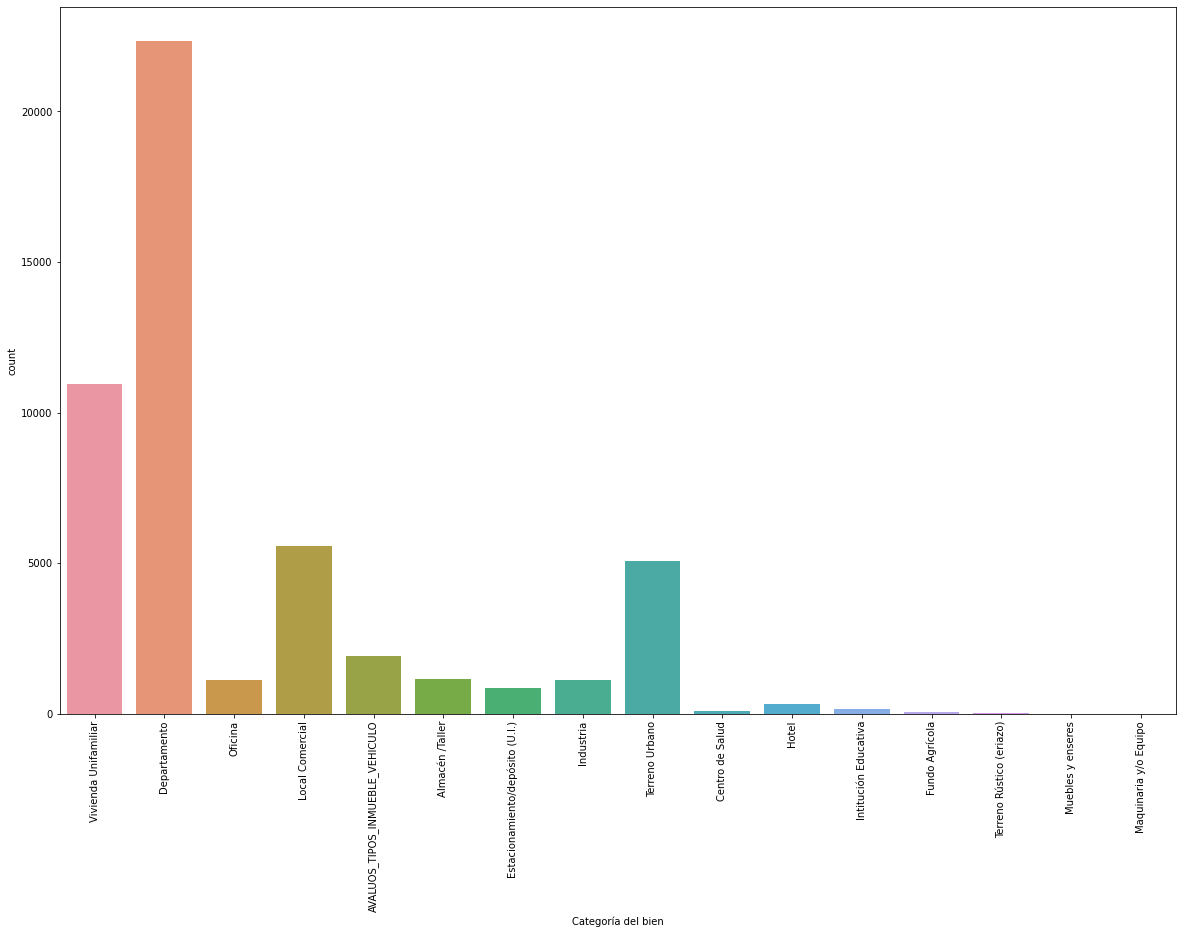

Estado de conservación


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


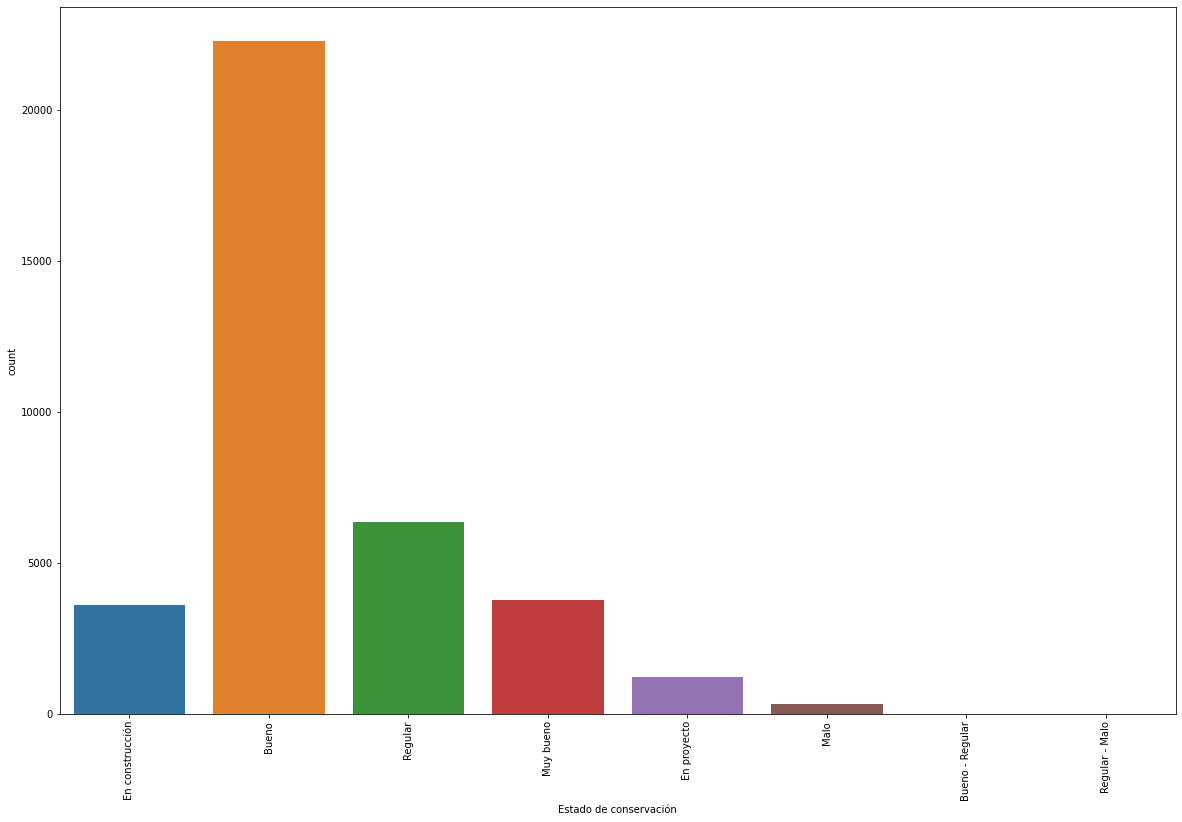

Método Representado


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


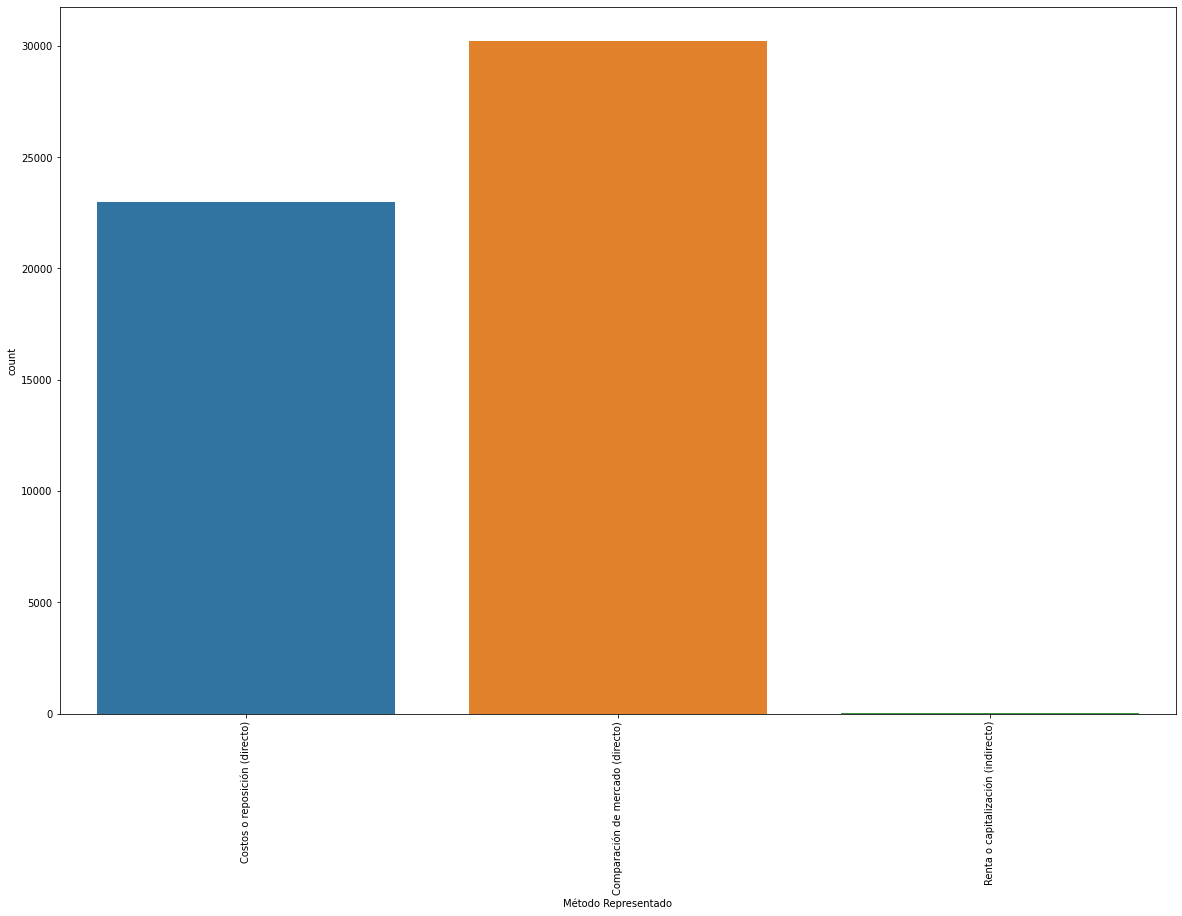

In [8]:
for c in cols_categoricas:
    print(c)
    print("="*64)
    plt.figure(figsize=(20,13))
    sns.countplot(df_train[c])
    plt.xticks(rotation=90)
    plt.show()

# **Distribucion de columnas numericas**

Esta seccion permite ver las graficos de variables numericas.
Destacados:
* Todos tienen valores atipicos, mi hipotesis es que estan relacionados con los valores atipicos en la distribucion del valor (usd)

In [9]:
cols_numericas

['Número de estacionamiento',
 'Depósitos',
 'Latitud (Decimal)',
 'Longitud (Decimal)',
 'Edad',
 'Área Terreno',
 'Área Construcción']

Número de estacionamiento


<Figure size 1440x936 with 0 Axes>

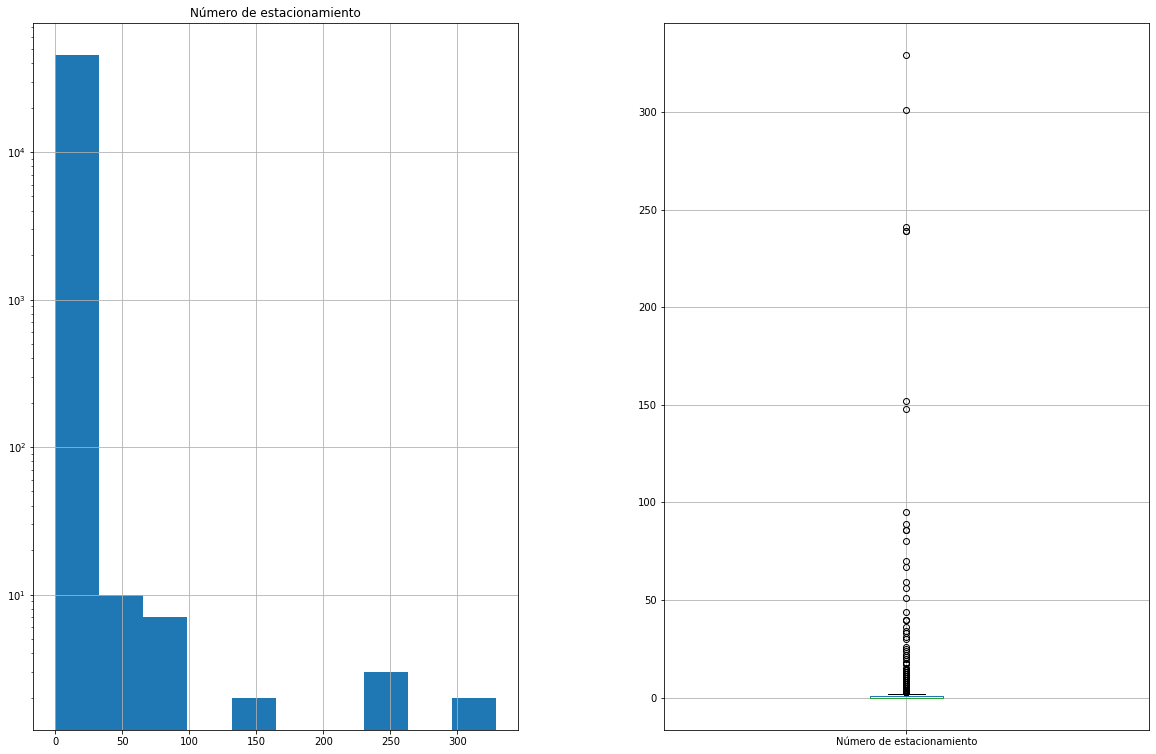

Depósitos


<Figure size 1440x936 with 0 Axes>

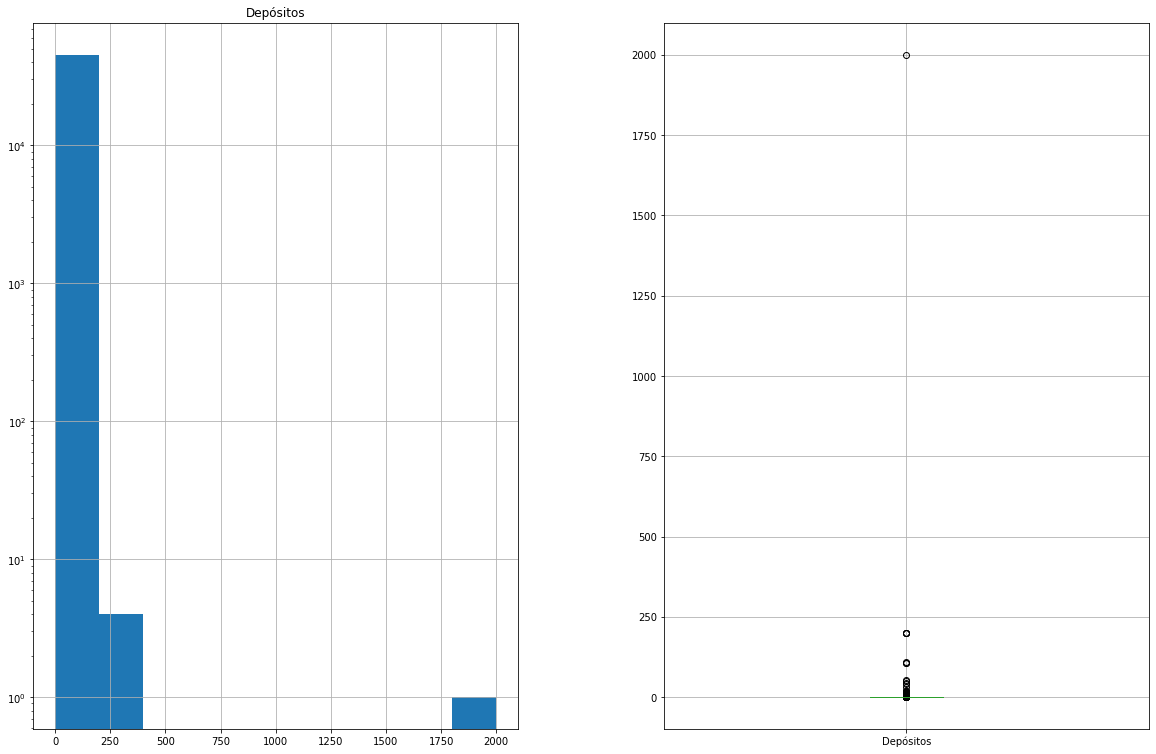

Latitud (Decimal)


<Figure size 1440x936 with 0 Axes>

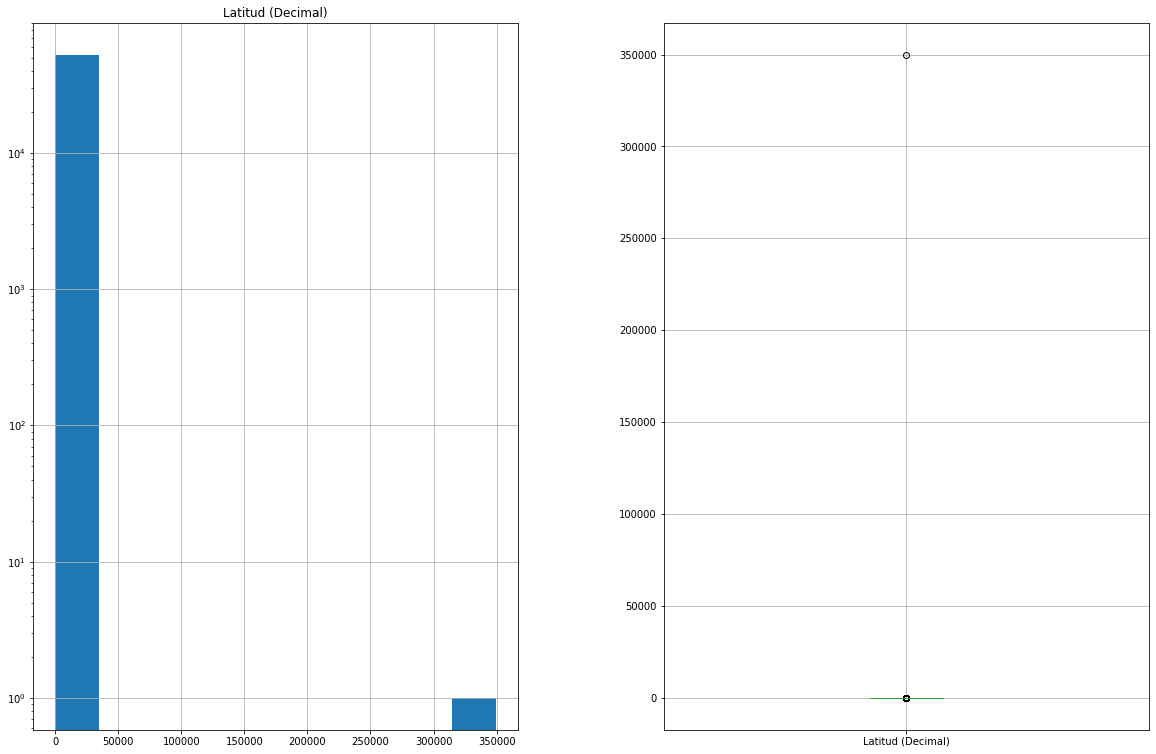

Longitud (Decimal)


<Figure size 1440x936 with 0 Axes>

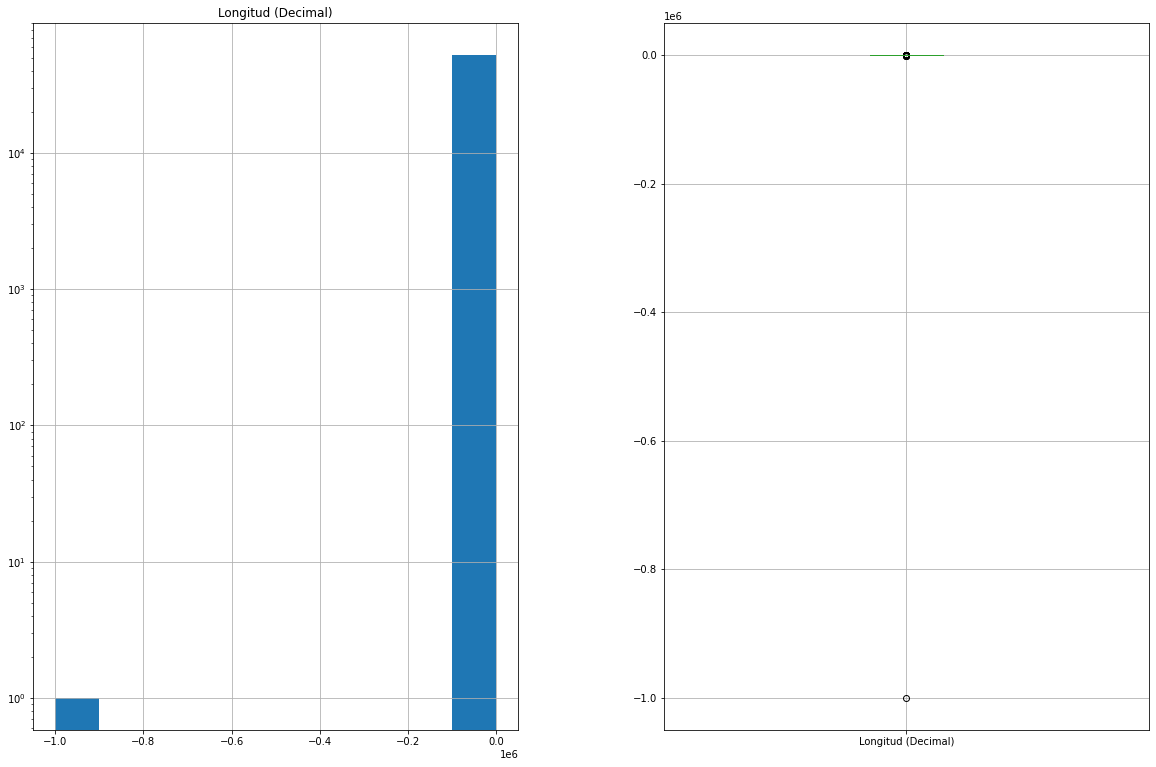

Edad


<Figure size 1440x936 with 0 Axes>

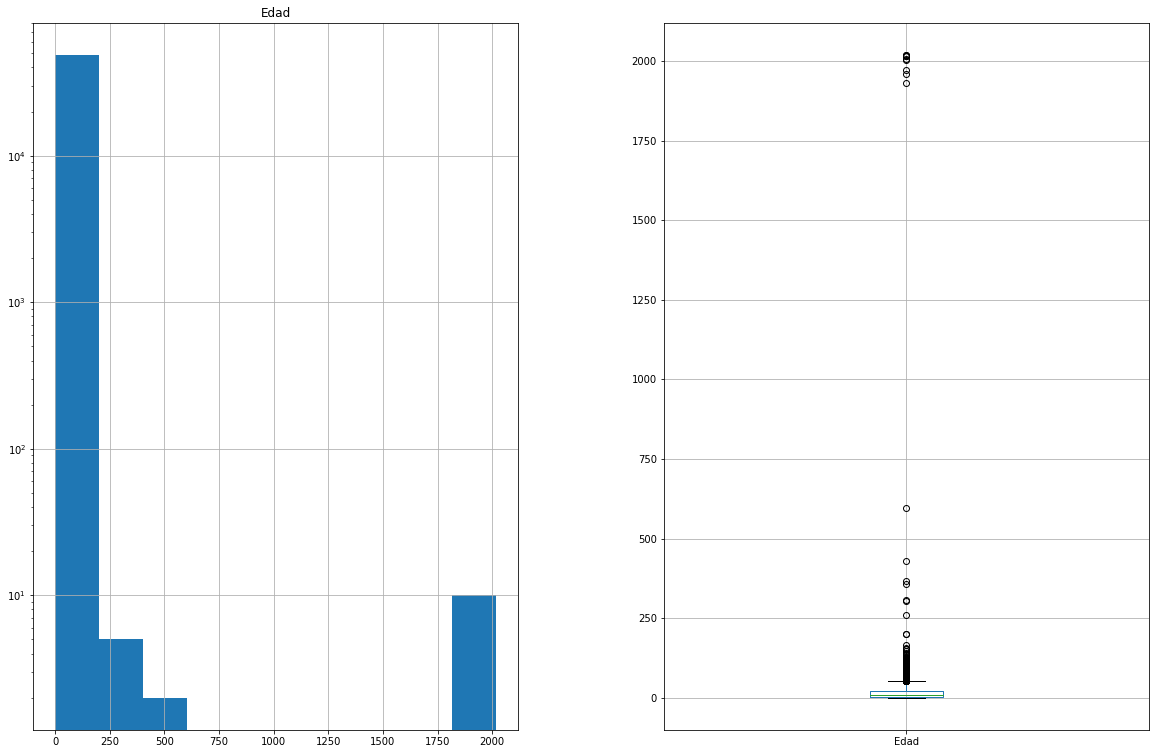

Área Terreno


<Figure size 1440x936 with 0 Axes>

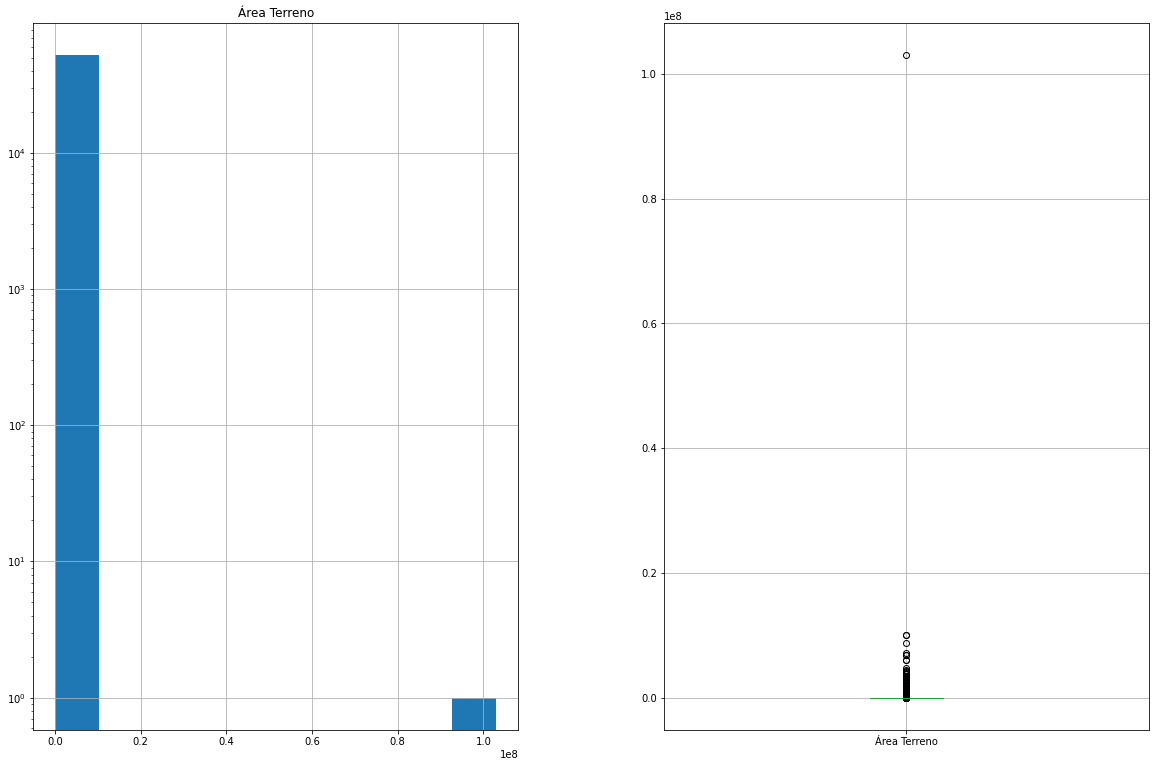

Área Construcción


<Figure size 1440x936 with 0 Axes>

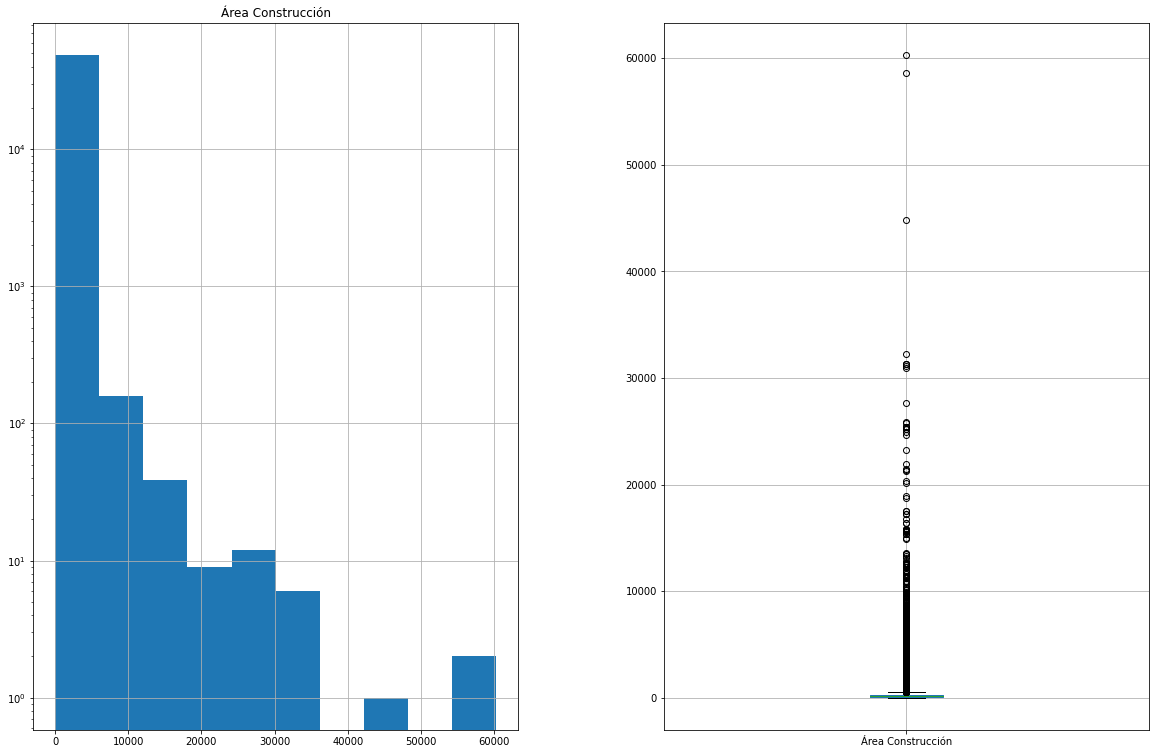

In [10]:
for c in cols_numericas:
    print(c)
    print("="*64)
    plt.figure(figsize=(20,13))
    fig, axes = plt.subplots(1, 2, figsize=(20,13))
    df_train.hist(column=[c],ax=axes[0],log=True)
    df_train.boxplot(column=[c],ax=axes[1])
    plt.show()

# **Limpiezas inmediatas**

Ahora se desarrollaran metodos para imputar los valores nulos en el dataset y en proyecciones posteriores

Hay algunas variables que pueden imputarse por la moda debido a:
* La cantidad de nulos en cada una de estas columnas es menor al 15% dentro del dataset
* El error al elegir la moda incorrecta es minimo puesto que en algunas columnas la distribucion es similar al conjunto natural N
* En cuanto a las columnas categoricas, los modas principales no difieren mucho semanticamente

In [11]:
col = "Tipo de vía"
print(col)
print("="*64)
print(df_train[col].value_counts())
print("")

col = "Número de estacionamiento"
print(col)
print("="*64)
print(df_train[col].value_counts())
print("")

col = "Depósitos"
print(col)
print("="*64)
print(df_train[col].value_counts())
print("")

col = "Método Representado"
print(col)
print("="*64)
print(df_train[col].value_counts())
print("")

Tipo de vía
CALLE        22165
AVENIDA      13509
JIRON         9965
PASAJE        1360
CARRETERA     1170
FUNDO           46
LOTE            12
SIN_VIA          9
MANZANA          6
PARCELA          1
Name: Tipo de vía, dtype: int64

Número de estacionamiento
0.0      32048
1.0      10621
2.0       2162
3.0        285
4.0         76
5.0         32
6.0         17
8.0         13
9.0          8
7.0          8
10.0         6
13.0         5
14.0         5
11.0         4
18.0         3
40.0         3
12.0         2
239.0        2
22.0         2
86.0         2
17.0         1
20.0         1
44.0         1
26.0         1
33.0         1
301.0        1
25.0         1
15.0         1
31.0         1
67.0         1
70.0         1
56.0         1
95.0         1
152.0        1
36.0         1
24.0         1
30.0         1
59.0         1
329.0        1
89.0         1
51.0         1
241.0        1
148.0        1
80.0         1
21.0         1
34.0         1
Name: Número de estacionamiento, dtype: int64

De

In [12]:
df_train["Tipo de vía"] = df_train["Tipo de vía"].fillna("CALLE")
df_train["Número de estacionamiento"] = df_train["Número de estacionamiento"].fillna(0)
df_train["Depósitos"] = df_train["Depósitos"].fillna(0)
df_train["Método Representado"] = df_train["Método Representado"].fillna("Comparación de mercado (directo)")
df_train.isnull().sum()

Fecha entrega del Informe        0
Tipo de vía                      0
Departamento                     0
Provincia                        0
Distrito                         0
Número de estacionamiento        0
Depósitos                        0
Latitud (Decimal)              863
Longitud (Decimal)             917
Categoría del bien            2449
Edad                          4789
Estado de conservación       15700
Método Representado              0
Área Terreno                  1153
Área Construcción             4493
Valor comercial (USD)            0
dtype: int64

# **Limpiar "Categoría del bien"**

Insight:
Cuando la area de construccion es cero, es muy probable que se trate de un terreno urbano

In [13]:
mask = df_train["Área Construcción"] == 0
df_train.loc[mask][["Área Terreno","Área Construcción","Categoría del bien"]].head(45)

,Área Terreno,Área Construcción,Categoría del bien
327,151.51,0.0,Departamento
330,500000.00,0.0,Terreno Urbano
363,147.03,0.0,Terreno Urbano
410,141000.00,0.0,Terreno Urbano
437,5000.00,0.0,Terreno Urbano
438,120.00,0.0,Terreno Urbano
499,41130.00,0.0,Terreno Urbano
503,2000000.00,0.0,Terreno Urbano
559,230.00,0.0,Terreno Urbano
576,5225.00,0.0,Terreno Urbano


In [14]:
mask = df_train["Área Construcción"] == 0
df_train.loc[mask,["Categoría del bien"]] = "Terreno Urbano"

Considero que las areas pueden segmentarse por la categoria (departamento,oficina,vivienda unifamiliar)

Voy a generar una columna adicional llamada "cociente_areas", que es la division de area construccion entre area terreno.

De esa forma la segmentacion sera robusta a la escala de los bienes raices

In [15]:
df_train_copy = df_train[["Área Terreno","Área Construcción","Categoría del bien"]].copy()
df_train_copy.dropna(inplace=True)

mask = df_train_copy["Área Construcción"] > 0
df_train_copy = df_train_copy[mask]

mask = df_train_copy["Área Terreno"] > 0
df_train_copy = df_train_copy[mask]

df_train_copy["cociente_areas"] = df_train_copy["Área Construcción"] / df_train_copy["Área Terreno"]
df_train_copy[["Área Terreno","Área Construcción","cociente_areas","Categoría del bien"]].head(20)

,Área Terreno,Área Construcción,cociente_areas,Categoría del bien
0,62.50,27.58,0.441280,Vivienda Unifamiliar
1,9.32,57.47,6.166309,Departamento
2,126.00,84.00,0.666667,Vivienda Unifamiliar
3,8.60,82.34,9.574419,Oficina
4,357.55,423.22,1.183667,Vivienda Unifamiliar
5,11.43,90.00,7.874016,Departamento
6,17.17,59.72,3.478160,Departamento
7,101.21,425.54,4.204525,Local Comercial
8,29.68,77.42,2.608491,Local Comercial
9,3.56,55.70,15.646067,Departamento


Acontinuacion se definiran las segmentaciones agrupando el dataset por categoria y calculando el rango de cociente

In [16]:
json_dataframe = []
for index,group in df_train_copy.groupby(["Categoría del bien"]):
    json_dataframe.append({
        "min_cociente":group["cociente_areas"].min(),
        "max_cociente":group["cociente_areas"].max(),
        "categoria": index
    })
df_cocientes = pd.DataFrame(json_dataframe)
df_cocientes.sort_values(by=["max_cociente"],inplace=True)
df_cocientes.head(20)

,min_cociente,max_cociente,categoria
11,5.593036e-04,0.163825,Terreno Rústico (eriazo)
8,2.801664e-02,9.834287,Intitución Educativa
2,3.329036e-01,9.971875,Centro de Salud
6,1.624695e-03,17.316941,Hotel
10,2.491241e-02,40.584670,Oficina
5,3.743060e-06,48.314091,Fundo Agrícola
1,4.444444e-04,57.989630,Almacén /Taller
4,1.600000e-03,64.925926,Estacionamiento/depósito (U.I.)
0,4.983256e-05,91.067416,AVALUOS_TIPOS_INMUEBLE_VEHICULO
9,9.967638e-07,473.295000,Local Comercial


Guarda el dataset de cocientes para futuras imputaciones

In [17]:
df_cocientes.to_csv("cocientes_areas.csv",index=False)

Imputacion de categorias dependiendo del area terreno y el area de construccion aplicando la segmentacion previa

In [18]:
mask1 = df_train["Categoría del bien"].isnull()
mask2 = df_train["Área Terreno"].notnull()
mask3 = df_train["Área Construcción"].notnull()
mask4 = mask1*mask2*mask3

df_train["mask_categoria"] = mask4

categoria_limpia = []
for index,row in df_train.iterrows():
    if row["mask_categoria"]:
        cociente = row["Área Construcción"] / row["Área Terreno"]
        categoria = None
        for i,r in df_cocientes.iterrows():
            if (cociente >= r["min_cociente"]) and (cociente <= r["max_cociente"]):
                categoria = r["categoria"]
                break;
        categoria_limpia.append(categoria)
    else:
        categoria_limpia.append(row["Categoría del bien"])
        
df_train.drop(["mask_categoria"],inplace=True,axis=1)
df_train["Categoría del bien"] = pd.Series(categoria_limpia)

En caso de no poder imputar las categorias faltantes con los metodos anteriores, se imputara por la moda que es "Departamento"

In [19]:
col = "Categoría del bien"
print(col)
print("="*64)
print(df_train[col].value_counts())
print("")

Categoría del bien
Departamento                       22336
Vivienda Unifamiliar               10929
Local Comercial                     5552
Terreno Urbano                      5210
Intitución Educativa                2057
AVALUOS_TIPOS_INMUEBLE_VEHICULO     1906
Oficina                             1186
Almacén /Taller                     1155
Industria                           1121
Estacionamiento/depósito (U.I.)      859
Hotel                                451
Terreno Rústico (eriazo)             156
Centro de Salud                      100
Fundo Agrícola                        58
Muebles y enseres                      1
Name: Categoría del bien, dtype: int64



In [20]:
df_train["Categoría del bien"] = df_train["Categoría del bien"].fillna("Departamento")
df_train.isnull().sum()

Fecha entrega del Informe        0
Tipo de vía                      0
Departamento                     0
Provincia                        0
Distrito                         0
Número de estacionamiento        0
Depósitos                        0
Latitud (Decimal)              863
Longitud (Decimal)             917
Categoría del bien               0
Edad                          4789
Estado de conservación       15700
Método Representado              0
Área Terreno                  1153
Área Construcción             4493
Valor comercial (USD)            0
dtype: int64

# **Limpieza de latitud y longitud**

La latitud y longitud son las coordenadas geograficas de los bienes. Hay otras columnas relacionadas a estas, por ejemplo "Departamento","Provincia","Distrito".

La pregunta es ¿Cual o cuales de estas columnas utilizar como referencia?

Si utilizo multiples datos estaria mezclando puntos dentro del mapa.
Entonces voy a definir un criterio para elegir la columna, la metrica de silueta cuantifica la "similitud" de un objeto perteneciente a un grupo comparandolo con el resto, cuanto mas cercano es a 1, mejor es la distribucion.

In [21]:
mask3 = (df_train["Latitud (Decimal)"] > -32)
mask1 = (df_train["Latitud (Decimal)"] < 325000) 

mask4 = (df_train["Longitud (Decimal)"] > -750)
mask2 = (df_train["Longitud (Decimal)"] < 0)


maskfinal = mask1*mask2*mask3*mask4

df_train_filtrado = df_train[maskfinal].copy()

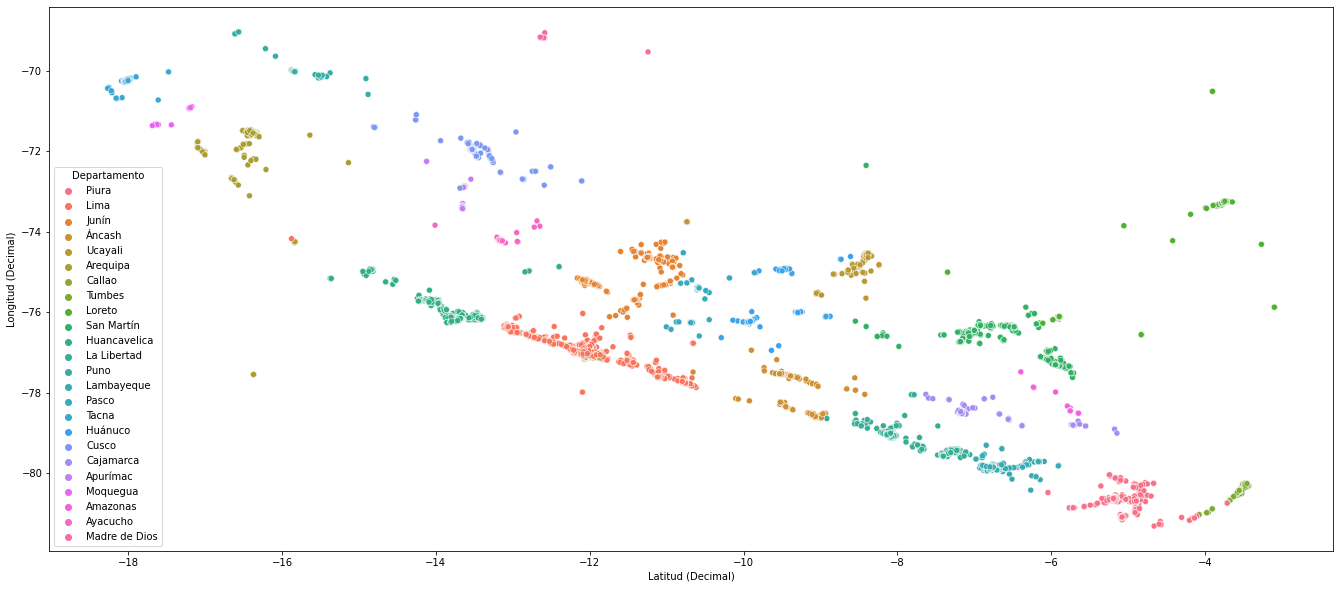

In [22]:
plt.figure(figsize=(23,10))
sns.scatterplot(x=df_train_filtrado["Latitud (Decimal)"], y=df_train_filtrado["Longitud (Decimal)"], hue=df_train_filtrado["Departamento"])
plt.show()

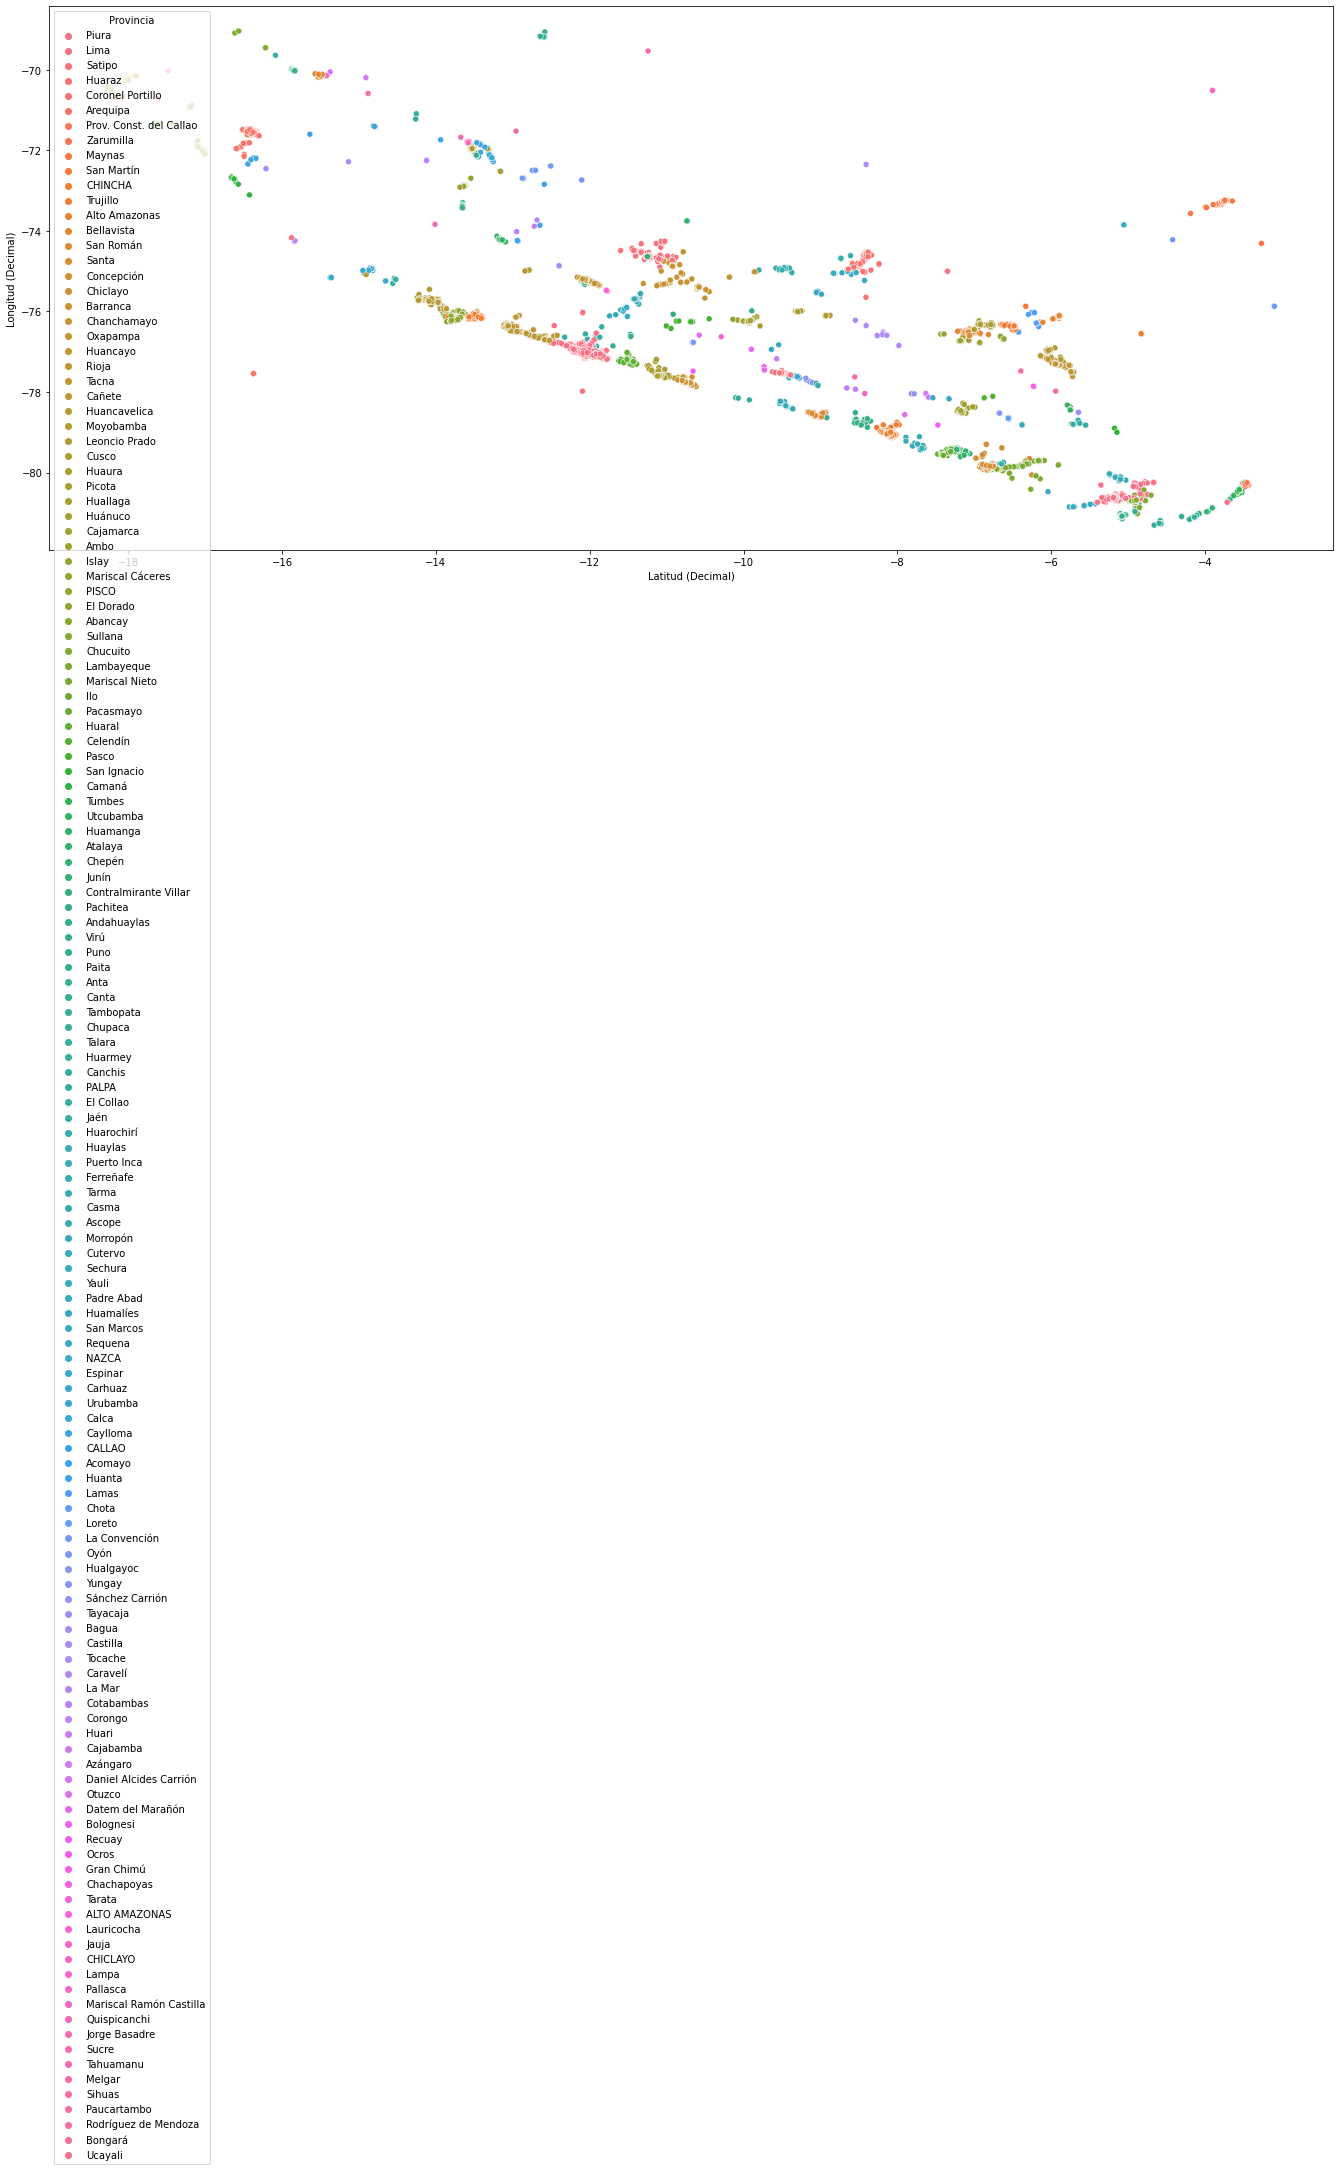

In [23]:
plt.figure(figsize=(23,10))
sns.scatterplot(x=df_train_filtrado["Latitud (Decimal)"], y=df_train_filtrado["Longitud (Decimal)"], hue=df_train_filtrado["Provincia"])
plt.show()

In [24]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [25]:
silueta = silhouette_score(df_train_filtrado[["Latitud (Decimal)","Longitud (Decimal)"]], df_train_filtrado["Departamento"])
print("Puntaje silueta agrupando por Departamento:",silueta)

Puntaje silueta agrupando por Departamento: 0.2445192143112243


In [26]:
silueta = silhouette_score(df_train_filtrado[["Latitud (Decimal)","Longitud (Decimal)"]], df_train_filtrado["Provincia"])
print("Puntaje silueta agrupando por Provincia:",silueta)

Puntaje silueta agrupando por Provincia: 0.37010230509479997


La columna "Provincia" tuvo mayor puntaje, sin embargo, yo busco un agrupamiento con mejor variabilidad y contornos mas claros.


Por lo tanto, defino a "Departamento" como la referencia

Agrupa por departamento y calcula la mediana de latitud y longitud por cada grupo.

Considerelo como los centroides de un algoritmo no supervisado

In [27]:
json_dataframe = []
for index,group in df_train_filtrado.groupby(["Departamento"]):
    json_dataframe.append({
        "lat_median":group["Latitud (Decimal)"].median(),
        "lon_median":group["Longitud (Decimal)"].median(),
        "departamento": index
    })
df_centros = pd.DataFrame(json_dataframe)
df_centros.set_index(["departamento"],inplace=True)
df_centros.head(20)

,lat_median,lon_median
departamento,,
Amazonas,-5.754014,-78.444101
Apurímac,-13.638792,-72.890389
Arequipa,-16.400974,-71.545114
Ayacucho,-13.160861,-74.222561
Cajamarca,-7.153880,-78.507822
Callao,-12.050353,-77.114169
Cusco,-13.528586,-71.951372
Huancavelica,-13.859010,-76.014340
Huánuco,-9.918299,-76.230482


Guarda el dataset de cocientes para futuras imputaciones

In [28]:
df_centros.to_csv("centros_lat_lon.csv")

In [29]:
def busqueda_latitud(x):
    if pd.isnull(x[0]):
        return df_centros.loc[x[1]]["lat_median"]
    else:
        return x[0]
    
def busqueda_longitud(x):
    if pd.isnull(x[0]):
        return df_centros.loc[x[1]]["lon_median"]
    else:
        return x[0]
    
df_train["Latitud (Decimal)"] = df_train[["Latitud (Decimal)","Departamento"]].apply(busqueda_latitud,axis=1)
df_train["Longitud (Decimal)"] = df_train[["Longitud (Decimal)","Departamento"]].apply(busqueda_longitud,axis=1)

In [30]:
df_train.isnull().sum()

Fecha entrega del Informe        0
Tipo de vía                      0
Departamento                     0
Provincia                        0
Distrito                         0
Número de estacionamiento        0
Depósitos                        0
Latitud (Decimal)                0
Longitud (Decimal)               0
Categoría del bien               0
Edad                          4789
Estado de conservación       15700
Método Representado              0
Área Terreno                  1153
Área Construcción             4493
Valor comercial (USD)            0
dtype: int64

# **Limpieza de "Edad"**

La edad mas habitual de los bienes es cero años

In [31]:
col = "Edad"
print(col)
print("="*64)
print(df_train[col].value_counts())
print("")

Edad
0.0      6719
1.0      5227
2.0      2265
5.0      2240
3.0      1929
         ... 
141.0       1
127.0       1
260.0       1
152.0       1
138.0       1
Name: Edad, Length: 152, dtype: int64



He notado que hay algunos registros con la edad mal escritas

In [32]:
mask = df_train["Edad"] > 600
df_train[mask].head(20)

,Fecha entrega del Informe,Tipo de vía,Departamento,Provincia,Distrito,Número de estacionamiento,Depósitos,Latitud (Decimal),Longitud (Decimal),Categoría del bien,Edad,Estado de conservación,Método Representado,Área Terreno,Área Construcción,Valor comercial (USD)
6071,2020-02-01,CALLE,Junín,Chanchamayo,Chanchamayo,0.0,0.0,-11.069803,-75.340211,Vivienda Unifamiliar,2017.0,Bueno,Costos o reposición (directo),290.00,854.00,395270
9507,2018-08-05,PASAJE,Loreto,Maynas,Iquitos,0.0,0.0,-3.757630,-73.251399,Local Comercial,2003.0,Regular,Costos o reposición (directo),250.00,338.00,224810
15623,2019-02-07,CALLE,La Libertad,Trujillo,Trujillo,0.0,0.0,-8.098712,-79.031691,Almacén /Taller,1971.0,Bueno,Comparación de mercado (directo),210.00,401.84,324233
22106,2016-04-11,CALLE,Arequipa,Arequipa,Miraflores,0.0,0.0,-16.393024,-71.520708,AVALUOS_TIPOS_INMUEBLE_VEHICULO,2016.0,NaN,Costos o reposición (directo),402.82,NaN,272974
30412,2018-07-23,AVENIDA,Piura,Piura,Castilla,0.0,0.0,-5.216933,-80.624678,Estacionamiento/depósito (U.I.),2018.0,Regular,Costos o reposición (directo),137.20,NaN,56089
34794,2019-11-04,AVENIDA,Lima,Lima,Jesús María,0.0,0.0,-12.067755,-77.045970,Terreno Urbano,1931.0,Malo,Costos o reposición (directo),73.80,73.80,120503
38294,2016-09-29,CALLE,Lambayeque,Chiclayo,Chiclayo,1.0,0.0,-6.782711,-79.848525,Vivienda Unifamiliar,2016.0,NaN,Costos o reposición (directo),200.00,440.00,165227
39734,2018-07-29,CALLE,Piura,Piura,Piura,0.0,0.0,-5.192961,-80.628671,Terreno Urbano,2018.0,Regular,Costos o reposición (directo),727.45,NaN,527058
50607,2019-06-23,CALLE,Lima,Lima,Chorrillos,0.0,0.0,-12.201426,-76.998327,Almacén /Taller,2005.0,Bueno,Costos o reposición (directo),6277.00,120.00,3333796
52616,2016-06-09,PASAJE,Lima,Lima,La Victoria,0.0,0.0,-12.069286,-77.015861,Estacionamiento/depósito (U.I.),1959.0,NaN,Costos o reposición (directo),31.13,60.65,112855


Correciones

In [33]:
df_train.loc[df_train["Edad"] == 2017, 'Edad'] = 3
df_train.loc[df_train["Edad"] == 2003, 'Edad'] = 15
df_train.loc[df_train["Edad"] == 1971, 'Edad'] = 48
df_train.loc[df_train["Edad"] == 2016, 'Edad'] = 0
df_train.loc[df_train["Edad"] == 2018, 'Edad'] = 0
df_train.loc[df_train["Edad"] == 1931, 'Edad'] = 88
df_train.loc[df_train["Edad"] == 2005, 'Edad'] = 14
df_train.loc[df_train["Edad"] == 1959, 'Edad'] = 57

Imputacion

In [34]:
df_train["Edad"] = df_train["Edad"].fillna(0)
df_train.isnull().sum()

Fecha entrega del Informe        0
Tipo de vía                      0
Departamento                     0
Provincia                        0
Distrito                         0
Número de estacionamiento        0
Depósitos                        0
Latitud (Decimal)                0
Longitud (Decimal)               0
Categoría del bien               0
Edad                             0
Estado de conservación       15700
Método Representado              0
Área Terreno                  1153
Área Construcción             4493
Valor comercial (USD)            0
dtype: int64

# **Limpieza de "Estado de conservación"**

Como mencione en secciones anteriores

La gran mayoria de bienes tienen estado de conservacion "Bueno".

Es factible imputar por la moda

In [35]:
col = "Estado de conservación"
print(col)
print("="*64)
print(df_train[col].value_counts())
print("")

Estado de conservación
Bueno              22281
Regular             6350
Muy bueno           3768
En construcción     3613
En proyecto         1204
Malo                 335
Bueno - Regular        2
Regular - Malo         1
Name: Estado de conservación, dtype: int64



In [36]:
df_train["Estado de conservación"] = df_train["Estado de conservación"].fillna("Bueno")
df_train.isnull().sum()

Fecha entrega del Informe       0
Tipo de vía                     0
Departamento                    0
Provincia                       0
Distrito                        0
Número de estacionamiento       0
Depósitos                       0
Latitud (Decimal)               0
Longitud (Decimal)              0
Categoría del bien              0
Edad                            0
Estado de conservación          0
Método Representado             0
Área Terreno                 1153
Área Construcción            4493
Valor comercial (USD)           0
dtype: int64

A continuacion elimina las filas que tengas las 2 areas como nulas

In [37]:
mask1 = df_train["Área Terreno"].isnull()
mask2 = df_train["Área Construcción"].isnull()
sum(mask1*mask2)

1114

In [38]:
mask1 = df_train["Área Terreno"].notnull()
mask2 = df_train["Área Construcción"].notnull()
mask = mask1+mask2
df_train = df_train[mask].copy()
df_train.isnull().sum()

Fecha entrega del Informe       0
Tipo de vía                     0
Departamento                    0
Provincia                       0
Distrito                        0
Número de estacionamiento       0
Depósitos                       0
Latitud (Decimal)               0
Longitud (Decimal)              0
Categoría del bien              0
Edad                            0
Estado de conservación          0
Método Representado             0
Área Terreno                   39
Área Construcción            3379
Valor comercial (USD)           0
dtype: int64

# **Limpieza de "Área Terreno"**

Pretendo imputar el area de terreno segun la categoria del bien y el area de construccion

Basicamente se busca en el dataset registros con la misma categoria y la area de construccion mas cercana numericamente

In [39]:
mask = df_train["Área Terreno"].isnull()
df_train_filtrado = df_train[mask].copy()
df_train_filtrado[["Categoría del bien","Área Construcción","Área Terreno"]].head()

,Categoría del bien,Área Construcción,Área Terreno
3072,Terreno Urbano,2.00,NaN
7153,AVALUOS_TIPOS_INMUEBLE_VEHICULO,4134.38,NaN
11806,Departamento,102.50,NaN
12041,Local Comercial,274.00,NaN
12986,Local Comercial,727.46,NaN


In [40]:
def busqueda_area_terreno(categoria,area_construccion):
    mask1 = df_train["Categoría del bien"] == categoria
    mask2 = df_train["Área Terreno"].notnull()
    mask = mask1*mask2
    df_train_filtrado = df_train[mask].copy()
    df_train_filtrado["diff"] = abs(df_train_filtrado["Área Construcción"] - area_construccion)
    mask = df_train_filtrado["diff"] == df_train_filtrado["diff"].min()
    df_train_filtrado = df_train_filtrado[mask].copy()
    return df_train_filtrado["Área Terreno"].mean()

In [41]:
areas_terrenos = []
for index,row in df_train.iterrows():
    if pd.isnull(row["Área Terreno"]):
        busqueda = busqueda_area_terreno(row["Categoría del bien"],row["Área Construcción"])
        areas_terrenos.append(busqueda)
    else:
        areas_terrenos.append(row["Área Terreno"])
df_train["Área Terreno"] = areas_terrenos
df_train.isnull().sum()

Fecha entrega del Informe       0
Tipo de vía                     0
Departamento                    0
Provincia                       0
Distrito                        0
Número de estacionamiento       0
Depósitos                       0
Latitud (Decimal)               0
Longitud (Decimal)              0
Categoría del bien              0
Edad                            0
Estado de conservación          0
Método Representado             0
Área Terreno                    0
Área Construcción            3379
Valor comercial (USD)           0
dtype: int64

# **Limpieza de "Área Construcción"**

Pretendo imputar el area de construccion segun la categoria del bien y el area de terreno

Basicamente se busca en el dataset registros con la misma categoria y la area de terreno mas cercana numericamente

In [42]:
mask = df_train["Área Construcción"].isnull()
df_train_filtrado = df_train[mask].copy()
df_train_filtrado[["Categoría del bien","Área Terreno","Área Construcción"]].head()

,Categoría del bien,Área Terreno,Área Construcción
17,Local Comercial,44.44,NaN
21,Departamento,141023.00,NaN
41,Terreno Urbano,2699.00,NaN
75,Terreno Urbano,9637.00,NaN
78,Terreno Urbano,174.56,NaN


In [43]:
def busqueda_area_construccion(categoria,area_terreno):
    mask1 = df_train["Categoría del bien"] == categoria
    mask2 = df_train["Área Construcción"].notnull()
    mask = mask1*mask2
    df_train_filtrado = df_train[mask].copy()
    df_train_filtrado["diff"] = abs(df_train_filtrado["Área Terreno"] - area_terreno)
    mask = df_train_filtrado["diff"] == df_train_filtrado["diff"].min()
    df_train_filtrado = df_train_filtrado[mask].copy()
    return df_train_filtrado["Área Construcción"].mean()

In [44]:
areas_construcciones = []
for index,row in df_train.iterrows():
    if pd.isnull(row["Área Construcción"]):
        busqueda = busqueda_area_construccion(row["Categoría del bien"],row["Área Terreno"])
        areas_construcciones.append(busqueda)
    else:
        areas_construcciones.append(row["Área Terreno"])
df_train["Área Construcción"] = areas_construcciones
df_train.isnull().sum()

Fecha entrega del Informe    0
Tipo de vía                  0
Departamento                 0
Provincia                    0
Distrito                     0
Número de estacionamiento    0
Depósitos                    0
Latitud (Decimal)            0
Longitud (Decimal)           0
Categoría del bien           0
Edad                         0
Estado de conservación       0
Método Representado          0
Área Terreno                 0
Área Construcción            0
Valor comercial (USD)        0
dtype: int64

Guarda el dataset de cocientes para futuras imputaciones

In [45]:
df_train.to_csv("train_v1.csv",index=False)

El desarrollo del prototipo continua en este notebook

https://www.kaggle.com/code/maximilianoalarcon/hackathon-bbva-2022-model-development/notebook

Nos vemos!!